# TW233MI - Régularisation et optimisation des modèles

## TD 1. Logistic Regression, de A à Z

L'objectif de ce TP est d'implémenter une fonction de coût $L(\theta)$, associée à un modèle de régression logistique $f_{\theta}$ et de l'optimiser par l'algorithme de descente de gradient. $\theta$ dénote ici les paramètres du modèle (modèle dit paramétrique).

Nous utiliserons un jeu de données d'admissions à un master (dataset $X,y$) pour expérimenter avec les algorithmes. Les deux premières colonnes du jeu de données $X$ contiennent les résultats d'examens (`exam scores`) et une troisième colonne contient les labels $y$ (`admis` au master ou non; cas de classification binaire). L'idée est de prédire l'admissibilité $y$ en fonction des résultats d'examens $X$ des années précédentes. Ce jeu de données sera utilisé pour entrainer un modèle de régression logistique $f_{\theta}$ qui prédit la probabilité d'admission $p$ d'un étudiant en fonction de ses résultats d'examens $X$.

#### Implémentations à completer
- Section 3: Completer la fonction `sigmoid()`: $s(z) = \frac{1}{1+e^{-z}}$
- Section 3: Completer la fonction `predict()` en utilisant la fonction sigmoid et np.dot(x, $\theta)$=$\sum_{j=1}^d x_j \theta_j$.
- Section 4: Completer la fonction `computeCost()`. 
- Section 4: Completer la fonction `computeGrad()`.
- Section 4: Completer la fonction `gradDescent()`.
- Section 4: Completer la fonction `irls()` en bonus (algorithme de Newton)

### 1. Rappels de cours

Le but de la régression logistique est de prédire la probabilité qu'une nouvelle instance $x$ appartienne à la classe 0 ou 1. Pour cela, on applique la [fonction sigmoïde](https://fr.wikipedia.org/wiki/Sigmo%C3%AFde_(math%C3%A9matiques)) pour calculer

\begin{equation}
    p_{\theta}(x)=\mathbb{P}(y=1|x^T \theta) = sigmoid(\theta_1 x + \theta_0) = \frac{1}{1+e^{-(\theta_1 x + \theta_0)}} \in [0,1]
\end{equation}

Dans notre cas, la fonction sigmoïde est utile car elle peut prendre une entrée avec n'importe quelle valeur de l'infini négatif à l'infini positif, alors que la sortie prend toujours des valeurs comprises entre zéro et un et est donc interprétable comme une probabilité.
Observez que la fonction est symétrique autour de 0, où la fonction prend la valeur 0,5. On prédit donc la classe Y = 1 avec
probabilité $p \geq 0,5$ si $\theta_1 x + \theta_0$ est non négatif, et 0 sinon. La régression logistique nous donne donc un classificateur linéaire. La décision
frontière séparant les deux classes prédites est la solution de

\begin{equation}
    \theta_1 x + \theta_0 = 0
\end{equation}

qui est un point si x est unidimensionnelle, une ligne si elle est bidimensionnelle, un plan dans le cas de trois dimensions, etc. La régression logistique
dit non seulement où se trouve la frontière entre les classes, mais dit aussi que les
probabilités dépendent de la distance de la frontière, et qu'ils vont vers
les extrêmes (0 et 1) plus rapidement lorsque $||\theta||$ est plus grand.

La régression logistique apprend les paramètres (ou poids) $\theta_j$ afin de maximiser la vraisemblance des données, probabilité qui peut s'exprimer comme un produit de distributions de Bernoulli (hypothèse iid):

\begin{equation}
    \mathbb{P}(Y|\theta) = \Pi_{i=1}^n p_{\theta}(x_i)^{y_i}  (1-p_{\theta}(x_i))^{1-y_i} 
\end{equation}

où $p_{\theta}(x_i)$ est la probabilité prédite que $x_i$ appartienne à la première classe, $y_i$ la classe de l'instance $i$ et $n$ le nombre d'instances. Nous définissons une fonction d'erreur (ou de coût)
en prenant le logarithme négatif de la vraisemblance et en appliquant la règle du produit pour les logarithmes :

\begin{equation}
    L(\theta)=-\frac{1}{n} log(\mathbb{P}(Y|\theta)) = -\frac{1}{n} \sum_{i=1}^n [y_i log(p_{\theta}(x_i)) + (1-y_i) log(1-p_{\theta}(x_i))]
\end{equation}

Ainsi, la régression logistique cherche à trouver les paramètres $\theta$ qui minimisent la fonction de coût $L(\theta)$. Une approche itérative consiste à initialiser les paramètres $\theta$ (aléatoirement) et les apprendre (optimiser) par descente de gradient avec:

\begin{equation}
    \nabla L (\theta) = \frac{1}{n} \sum_{i=1}^n (p_{\theta}(x_i) - y_i) x_i
\end{equation}

### 2. Load and inspect the data

In [1]:
# Load the dataset
import numpy as np
data = np.loadtxt('../td/data/exams.txt', delimiter=',')
X = data[:, 0:2] # the first two columns contains the exam scores
y = data[:, 2] # the third column contains the label (admitted or not)

In [2]:
# Normalize X to have values in [0,1] (original scores in [0,100])
X = X/100

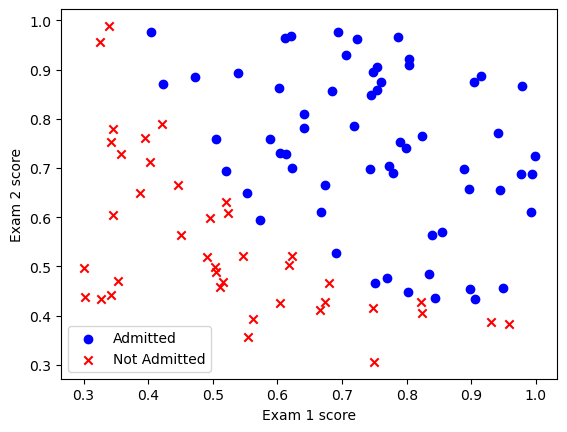

In [3]:
# Plot the training data 
import matplotlib.pyplot as plt
pos = np.where(y == 1)
neg = np.where(y == 0)
plt.scatter(X[pos, 0], X[pos, 1], marker='o', c='b')
plt.scatter(X[neg, 0], X[neg, 1], marker='x', c='r')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(['Admitted', 'Not Admitted'])
plt.show()

This dataset is composed by $n=100$ observations. Thus, $X$ is a matrix of size (100, 2) and $y$ is a vector of size (100). We add a column of ones to $X$ (intercept) to simply write $\theta_1 x_1 + \theta_0$ as np.dot($\theta$,X) for a linear model.

In [4]:
#Add intercept term to X
X_new = np.ones((X.shape[0], 3))
X_new[:, 1:3] = X
X = X_new

### 3. Implement logistic regression

In [5]:
from math import e, pow

In [6]:
def sigmoid(z):
    # Computes the sigmoid of z.
    
    ### À compléter. Calculer sigmoid(z) ###
    g = 1.0 / (1 + e**(-z))  
    ### ### ### ### ### ### ### ### ### ###
    
    return g

In [7]:
def predict(theta, X):
    # Predict whether the label is 0 or 1 using learned logistic regression parameters theta.
    # The threshold is set at 0.5
    
    n = X.shape[0] # number of training examples
    c = np.zeros(n) # predicted classes of training examples
    p = np.zeros(n) # logistic regression outputs of training examples
    
    ### À compléter. Calculer p[i] et c[i] ###
    for i in range(n):
        p[i] = sigmoid(np.dot(X[i,:],theta))
        if p[i] > 0.5:
            c[i] = 1
        else:
            c[i] = 0
    ### ### ### ### ### ### ### ### ### ###
    
    return c

### 4. Optimize your model

In [8]:
def computeCost(theta, X, y, eps=0.00000001): 
    # Computes the cost of using theta as the parameter for logistic regression. 
    
    n = X.shape[0] # number of training examples
    L = 0
    
    ### À compléter. Calculer la fonction de coût L associée à theta, X et y ###
    for i in range(n):
        L += (-y[i] * np.log(sigmoid(np.dot(X[i,:],theta))+eps) - (1 - y[i]) * np.log(1 - sigmoid(np.dot(X[i,:],theta))+eps))
    L /= n
    ### ### ### ### ### ### ### ### ### ###
    
    return L

In [9]:
def computeGrad(theta, X, y):
    # Computes the gradient of the cost with respect to the parameters.

    n, d = X.shape # number of training examples
    grad = np.zeros(d) # initialize gradient
    
    ### À compléter. Calculer le gradient de la fonction de coût par rapport à theta ###
    for j in range(d):
        for i in range(n):
            grad[j] += (sigmoid(np.dot(X[i,:],theta)) - y[i]) * X[i,j] 
    grad /= n 
    ### ### ### ### ### ### ### ### ### ###
    
    return grad

#### Optimisation par descente de gradient

We initialize parameter $\theta$ with zero and will minimize the value of the `computeCost()` function, with respect to the parameter $\theta$, using the `computeGrad()` function, that computes the gradient of the cost function. The function returns the learned values of parameter $\theta$

In [10]:
def gradDescent(X, y, lr = 1.0, n_iter = 1000):
    # Returns logistic regression parameters theta, learned by gradient descent on X,y
    
    # Initialize parameters 
    theta = np.zeros((3,1))
    print("Initial loss", computeCost(theta, X, y))
    for k in range(n_iter):
        
        ### À compléter. Implémenter une itération de algorithme de descente de gradient ###
        theta = theta - lr*computeGrad(theta, X, y).reshape((-1,1))
        ### ### ### ### ### ### ### ### ### ###

    print("Final loss", computeCost(theta, X, y))
    return theta

In [11]:
theta = gradDescent(X, y, n_iter = 1000)
theta.shape

Initial loss [0.69314716]
Final loss [0.25842281]


(3, 1)

#### Méthode de Newton (bonus)

In [12]:
def irls(X, y, theta):
    
    ### À compléter. Implémenter une itération de algorithme de Newton pour la régression logistique ###
    p = sigmoid(np.dot(X, theta)) # shape (n,1)   
    
    SX = X*(p-p*p ).reshape(-1 ,1) # shape (n,d) 
    XSX = np.dot(X.T, SX) # shape (d,d)
    SXtheta = np.dot(SX, theta) # shape (n,1)
    
    b = SXtheta+y.reshape(-1,1)-p # shape (n,1)        
    theta = np.linalg.solve(XSX, np.dot(X.T, b))
    ### ### ### ### ### ### ### ### ### ###
    
    return theta

In [13]:
def newtonMethod(X, y, n_iter = 100):
    # Returns logistic regression parameters theta, learned by Newton's method
    
    # Initialize parameters
    theta = np.zeros((3,1))
    print("Initial loss", computeCost(theta, X, y))
    for k in range(n_iter):
        theta = irls(X, y, theta)

    print("Final loss", computeCost(theta, X, y))
    return theta

In [14]:
#theta = newtonMethod(X, y, n_iter = 100)
#theta.shape

### 5. Analyser les resultats

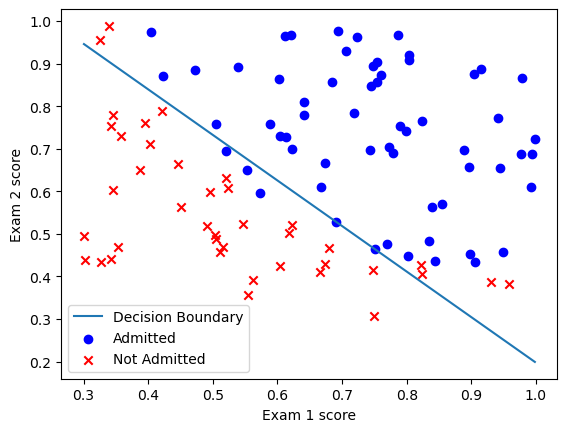

In [15]:
# Plot the decision boundary
plot_x = np.array([min(X[:, 1]), max(X[:, 1])])
plot_y = (- 1.0 / theta[2]) * (theta[1] * plot_x + theta[0])
plt.plot(plot_x, plot_y)
plt.scatter(X[pos, 1], X[pos, 2], marker='o', c='b')
plt.scatter(X[neg, 1], X[neg, 2], marker='x', c='r')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(['Decision Boundary', 'Admitted', 'Not Admitted'])
plt.show()

In [16]:
# Compute accuracy on the training set
p = predict(np.array(theta), X)
counter = 0
for i in range(y.size):
    if p[i] == y[i]:
        counter += 1
print ('Train Accuracy: %f' % (counter / float(y.size) * 100.0))

Train Accuracy: 90.000000


In [17]:
### À tester: Rerun gradDescent with a different value for n_iter. How to choose n_iter? ###
### À tester: Rerun gradDescent with a different value for the learning rate (lr). How to choose lr? ###

### Prochain TP
- Implementer des variantes de descente de gradient: Coordinate Descent (CD), Stochastic Gradient Descent (SGD)
- Nouveau jeu de données, with feature engineering and model regularisation